In [1]:
# general imports
import pandas as pd
import numpy as np
import itertools

# display options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# custom helper functions
%load_ext autoreload
%autoreload 2
from helper.general_helper import *


# view plotly in jupyter 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

C:\Users\walke\anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [15]:
x = getDF('../../data/meta_Health_and_Personal_Care.json.gz')

In [17]:
y = getDF('../../data/reviews_Health_and_Personal_Care_5.json.gz')

In [18]:
y.head()

reviewerID        asin                reviewerName   helpful                                         reviewText  overall                                summary  unixReviewTime   reviewTime
0   ALC5GH8CAMAI7  159985130X                        AnnN    [1, 1]  This is a great little gadget to have around. ...      5.0                    Handy little gadget      1294185600   01 5, 2011
1   AHKSURW85PJUE  159985130X         AZ buyer "AZ buyer"    [1, 1]  I would recommend this for a travel magnifier ...      4.0  Small & may need to encourage battery      1329523200  02 18, 2012
2   A38RMU1Y5TDP9  159985130X  Bob Tobias "Robert Tobias"  [75, 77]  What I liked was the quality of the lens and t...      4.0                Very good but not great      1275955200   06 8, 2010
3  A1XZUG7DFXXOS4  159985130X                   Cat lover  [56, 60]  Love the Great point light pocket magnifier!  ...      4.0           great addition to your purse      1202428800   02 8, 2008
4  A1MS3M7M7AM13X  159985130X                  Cricketoes    [1, 1]  This is very nice. You pull out on the magnifi...      5.0              Very nice and convenient.      1313452800  08 16, 2011

In [186]:
app_df = getDF('../../data/reviews_Apps_for_Android_5.json.gz')
# app_df.to_csv(r'../../app_df.csv', index=False)

In [187]:
meta_df = getDF('../../data/meta_Apps_for_Android.json.gz')
# meta_df.to_csv(r'../../meta_df.csv', index=False)

In [8]:
meta_df.head()

asin                                            related                                  categories salesRank  price
0  B004A9SDD8  {'also_bought': ['B006M3K874', 'B00F85SMOI', '...                  [[Apps for Android, Kids]]       NaN    NaN
1  B004AFQAUA  {'also_bought': ['B005UDD1R6', 'B00LBH2UMM', '...  [[Apps for Android, Music, Music Players]]       NaN    NaN
2  B004AGCR1K  {'also_viewed': ['B00A7W29BE', 'B00I5PB9UM', '...          [[Apps for Android, Productivity]]       NaN    NaN
3  B004AHBBPW  {'also_bought': ['B006T2U1V6', 'B00FBCIYZU', '...             [[Apps for Android, Reference]]       NaN    NaN
4  B004ALFHV2  {'also_bought': ['B00CA6LZAG', 'B00FE5ZF4W', '...         [[Apps for Android, Communication]]       NaN    NaN

In [9]:
app_df.head()

reviewerID        asin                   reviewerName helpful                                         reviewText  overall                                            summary  unixReviewTime   reviewTime
0  A1N4O8VOJZTDVB  B004A9SDD8                 Annette Yancey  [1, 1]  Loves the song, so he really couldn't wait to ...      3.0                                        Really cute      1383350400   11 2, 2013
1  A2HQWU6HUKIEC7  B004A9SDD8        Audiobook lover "Kathy"  [0, 0]  Oh, how my little grandson loves this app. He'...      5.0                                2-year-old loves it      1323043200   12 5, 2011
2  A1SXASF6GYG96I  B004A9SDD8                  Barbara Gibbs  [0, 0]  I found this at a perfect time since my daught...      5.0                                           Fun game      1337558400  05 21, 2012
3  A2B54P9ZDYH167  B004A9SDD8  Brooke Greenstreet "Babylove"  [3, 4]  My 1 year old goes back to this game over and ...      5.0                               We love our Monkeys!      1354752000   12 6, 2012
4   AFOFZDTX5UC6D  B004A9SDD8                     C. Galindo  [1, 1]  There are three different versions of the song...      5.0  This is my granddaughters favorite app on my K...      1391212800   02 1, 2014

In [117]:
merged_df = app_df.merge(meta_df, how='left', on='asin')

#### Feature Engineering

##### mapping review count as high, medium, and low with iqr

In [118]:
# drop salesRank and replace with reviewcount as all values are null
# merged_df.drop('salesRank', axis=1, inplace=True)

# product review count
review_count = merged_df.groupby('asin').count().sort_values(by='reviewerID', ascending=False)['reviewerID']

# quartiles of review counts, these will be our mappings for feature engineering
quartile_list = review_count.quantile([0.25,0.5,0.75]).tolist()
# print(quartile_list)

# create dict of asin and low, med, high by quartile
prod_review_count_dict = dict(review_count.apply(lambda x: review_map(x)))

# create new column, product review counts with mapped dict
merged_df['prod_review_counts'] = merged_df['asin'].apply(lambda x: prod_review_count_dict[x])



# transforming categories first pass, flatten lists
merged_df.categories = merged_df.categories.apply(lambda x: list(itertools.chain(*x)))

# second pass
merged_df.categories = merged_df.categories.apply(lambda x: " ".join(x[1:]))



# creating free column based on price, 0 is not free, 1 is free
merged_df['free'] = merged_df.price.apply(lambda x: 0 if x > 0 else 1)



# drop empty column
merged_df.drop('salesRank', axis=1, inplace=True)

# fill free apps with 0
merged_df.price.fillna(0, inplace=True)

[7.0, 14.0, 41.0]


##### general preprocessing

In [164]:
merged_df['percent_helpful'] = merged_df.helpful.apply(lambda x: x[0] / x[1] if x [1] > 0 else 0)

In [167]:
merged_df['reviewTime'] = pd.to_datetime(merged_df['reviewTime']).dt.date

In [188]:
# merged_df.to_csv(r'../../merged_df.csv', index=False)

#### Questions
* distribution of price
* distribution of review time


#### feature engineering
* item_sim:
    * review text per item for similarity
    * categories
* user_sim:
    * number of reviews
    * median ratings
    * favorite category
    
    

#### ideas

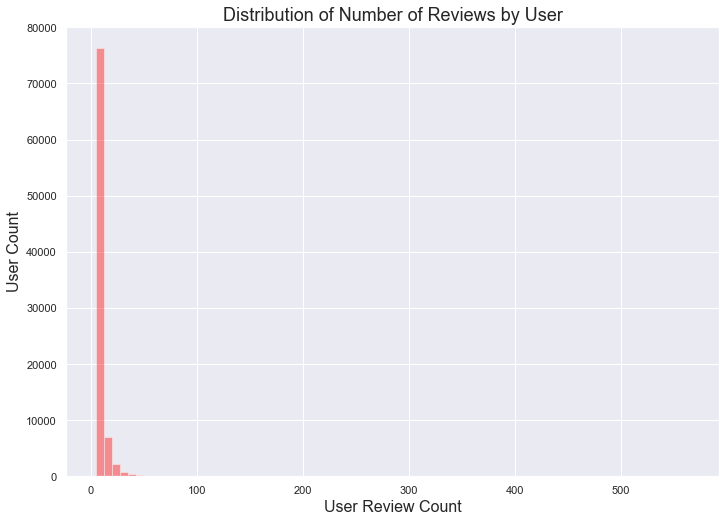

In [58]:
# Visualize the distribution of Review Counts

review_count = app_df.groupby('reviewerID').count()
figure = sns.distplot(review_count['asin'], kde=False, color='red', bins=75)
plt.title('Distribution of Number of Reviews by User', fontsize=18)
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.xlabel('User Review Count', fontsize=16)
plt.ylabel('User Count', fontsize=16);

In [62]:
review_count

asin
B00FAPF5U0    6282
B0086700CM    4637
B00992CF6W    4018
B009UX2YAC    3814
B0064X7B4A    3763
              ... 
B004XVLYKC       5
B0075ADHVW       5
B00BSWJFJG       5
B00BTB2U0C       5
B006OIK688       5
Name: reviewerID, Length: 13209, dtype: int64

In [64]:
# lets look at this with more detail
max = review_count.max()
min = review_count.min()
average = review_count.mean()
median = review_count.median()

print(f"The max number of reviews by user is {max} and the min number of reviews by user is {min}")
print(f"The average number of reviews by user is {average} and the median number of reviews by user is {median}")

The max number of reviews by user is 6282 and the min number of reviews by user is 5
The average number of reviews by user is 57.001816942993415 and the median number of reviews by user is 14.0


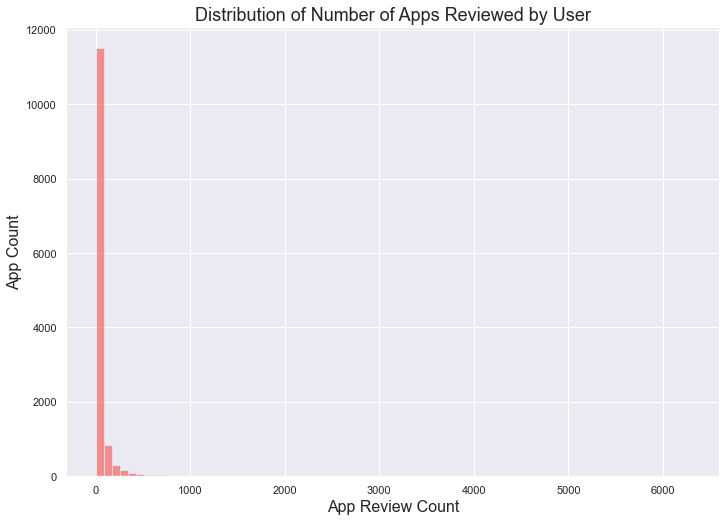

In [60]:
# Visualize the distribution of apps reviewed
app_count = app_df.groupby('asin').count()

figure = sns.distplot(app_count['reviewerID'], kde=False, color='red', bins=75)
plt.title('Distribution of Number of Apps Reviewed by User', fontsize=18)
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.xlabel('App Review Count', fontsize=16)
plt.ylabel('App Count', fontsize=16);

In [65]:
# Lets look at this distribution in more detail
max = app_count.reviewerID.max()
min = app_count.reviewerID.min()
average = app_count.reviewerID.mean()
median = app_count.reviewerID.median()

print(f"The max number of reviews for apps is {max} and the min number of reviews for apps is {min}")
print(f"The average number of reviews for apps is {round(average, 3)} and the median number of reviews for apps is {median}")

The max number of reviews for apps is 6282 and the min number of reviews for apps is 5
The average number of reviews for apps is 57.002 and the median number of reviews for apps is 14.0


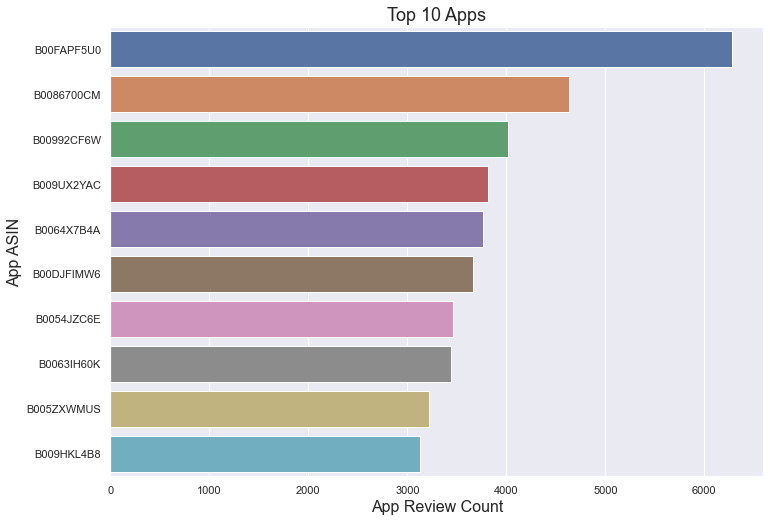

In [146]:
# top 10 most reviewed apps
# ax = sns.barplot(x="tip", y="day", data=tips)

# top 10 apps
top_10_reviewed_apps = app_count.sort_values(by='reviewerID', ascending=False)['reviewerID'][:10]

# idx_list = top_10_reviewed_apps.index.tolist()
figure = sns.barplot(x=top_10_reviewed_apps, y=top_10_reviewed_apps.index)
plt.title('Top 10 Apps', fontsize=18)
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.xlabel('App Review Count', fontsize=16)
plt.ylabel('App ASIN', fontsize=16);

In [142]:
top_10_cats = merged_df.groupby('categories').count().sort_values(by='asin', ascending=False)['asin'][:10]
top_10_cats

categories
Games                                      536135
Entertainment                               39424
Productivity                                17162
Games Video Games Fire TV Digital Games     15700
Kids                                        11209
Education                                   10736
Social Networking                           10296
Utilities                                    9618
Health & Fitness                             9132
Lifestyle                                    8129
Name: asin, dtype: int64

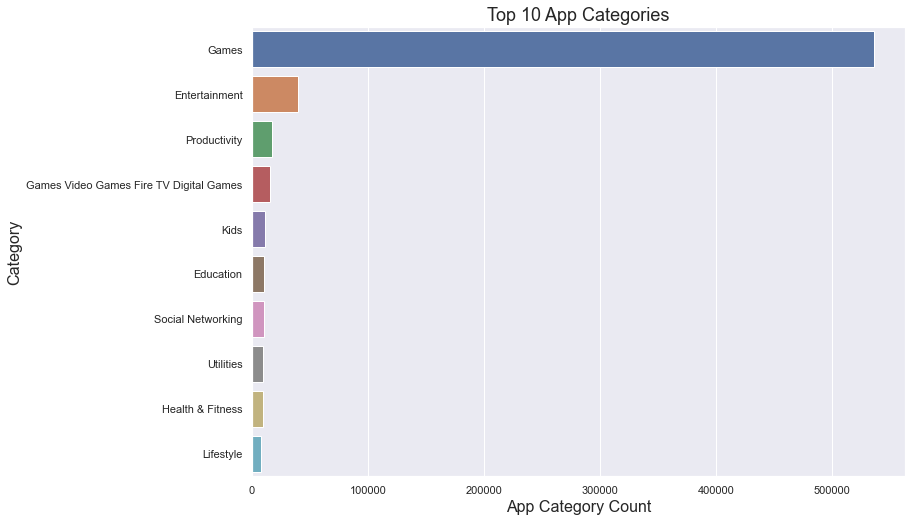

In [147]:
figure = sns.barplot(x=top_10_cats, y=top_10_cats.index)
plt.title('Top 10 Prevelant App Categories', fontsize=18)
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.xlabel('App Category Count', fontsize=16)
plt.ylabel('Category', fontsize=16);

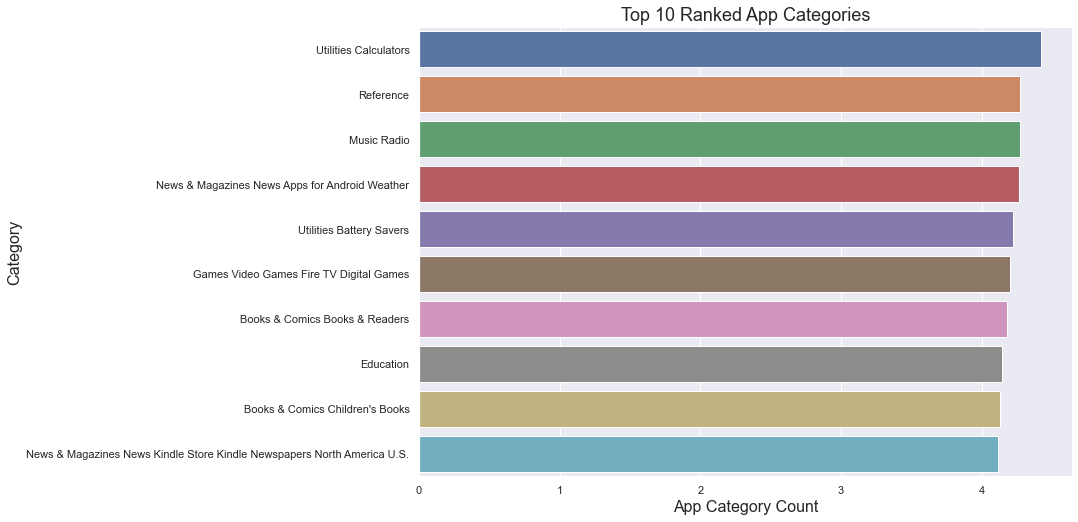

In [155]:
highest_rank = merged_df.groupby('categories').mean().sort_values(by='overall', ascending=False)['overall'][:10]

figure = sns.barplot(x=highest_rank, y=highest_rank.index)
plt.title('Top 10 Ranked App Categories', fontsize=18)
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.xlabel('App Category Count', fontsize=16)
plt.ylabel('Category', fontsize=16);

In [182]:
review_time = merged_df.groupby('reviewTime').count()['reviewerID'][5:]

In [183]:
review_time

reviewTime
2011-03-22    201
2011-03-23     89
2011-03-24     58
2011-03-25     78
2011-03-26     62
             ... 
2014-07-19    452
2014-07-20    585
2014-07-21    595
2014-07-22    672
2014-07-23    104
Name: reviewerID, Length: 1220, dtype: int64

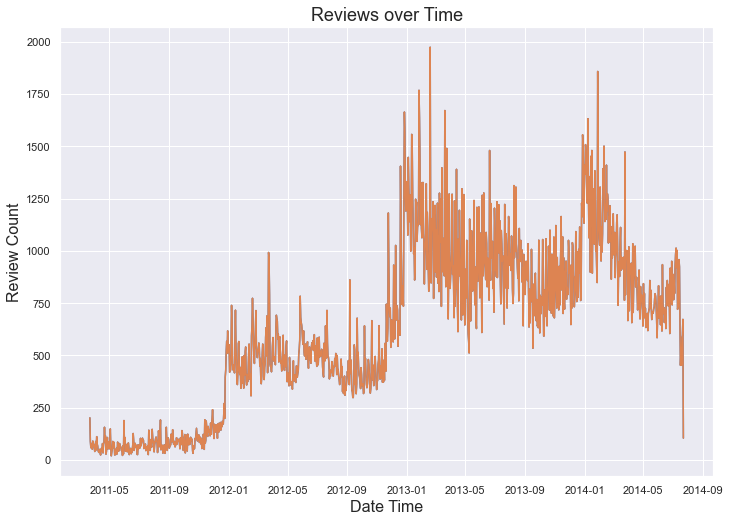

In [185]:
sns.lineplot(x=review_time.index, y=review_time)

figure = sns.lineplot(x=review_time.index, y=review_time)
plt.title('Reviews over Time', fontsize=18)
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.xlabel('Date Time', fontsize=16)
plt.ylabel('Review Count', fontsize=16);

In [ ]:
# use 
highest_rated_movies = ratings.loc[(ratings['rating'] > 4.25) & (ratings['num of ratings'] > 20)]
highest_rated_movies

In [2]:
df = pd.read_csv('../../merged_df.csv')

In [14]:

cut_down = df.groupby('reviewerID').filter(lambda x: len(x) >= 20)
cut_down

reviewerID        asin                   reviewerName   helpful                                         reviewText  overall                                            summary  unixReviewTime  reviewTime                                            related           categories  price prod_review_counts  free  percent_helpful
1       A2HQWU6HUKIEC7  B004A9SDD8        Audiobook lover "Kathy"    [0, 0]  Oh, how my little grandson loves this app. He'...      5.0                                2-year-old loves it      1323043200  2011-12-05  {'also_bought': ['B006M3K874', 'B00F85SMOI', '...                 Kids    0.0             medium     1         0.000000
21      A2ETSATXP9MTZ6  B004AFQAUA                Amazon Customer    [1, 1]  I really don't think I could live without Rhap...      5.0                                    I love Rhapsody      1358553600  2013-01-19  {'also_bought': ['B005UDD1R6', 'B00LBH2UMM', '...  Music Music Players    0.0               high     1         1.000000
31       AK3IFCDU88TI9  B004AFQAUA                  C. Riostirado    [2, 2]  I love my rhapsody!! I was so glad that I coul...      4.0                                           Love it!      1385164800  2013-11-23  {'also_bought': ['B005UDD1R6', 'B00LBH2UMM', '...  Music Music Players    0.0               high     1         1.000000
32      A39SUI22Z4O4BM  B004AFQAUA                      dianabeld    [0, 0]  this app I do not use. and not sure how to get...      5.0                                            rapsody      1359158400  2013-01-26  {'also_bought': ['B005UDD1R6', 'B00LBH2UMM', '...  Music Music Players    0.0               high     1         0.000000
47      A1LHJ32NVLJ5QS  B004AFQAUA                       jodystaf    [4, 5]  You have to go onto a computer to sign up. Wel...      2.0                                                why      1364515200  2013-03-29  {'also_bought': ['B005UDD1R6', 'B00LBH2UMM', '...  Music Music Players    0.0               high     1         0.800000
...                ...         ...                            ...       ...                                                ...      ...                                                ...             ...         ...                                                ...                  ...    ...                ...   ...              ...
752914  A2EDY22TXLBRH5  B00LP1MVSW                    Cool person  [14, 15]  This game is one of the most realistic dinosau...      5.0  Wanting a realistic dinosaur sensation? Start ...      1405987200  2014-07-22  {'also_bought': ['B00FAX6XQC', 'B00BFUUMO8', '...                Games    0.0                low     1         0.933333
752917  A1VM5Y6BL07X9X  B00LP1MVSW                Praetorianus_65  [19, 21]  The tutorial is excellent, smooth graphics, ni...      5.0                                          Great fun      1405987200  2014-07-22  {'also_bought': ['B00FAX6XQC', 'B00BFUUMO8', '...                Games    0.0                low     1         0.904762
752923   AO8EO4KL0SR1I  B00LUEMK44  Cheryl D. Jones "Babygirlcwj"    [0, 0]  Another great Jewels game which keeps you thin...      5.0                                     Excellent Game      1405900800  2014-07-21  {'also_bought': ['B00KTDD69A', 'B00LAEGVDK', '...                Games    0.0             medium     1         0.000000
752935  A1IHFHA5LI9SGI  B00LUEMK44                  redhatflusher    [0, 0]  I find this the best jewels star ever. There s...      5.0                                       entertaining      1405814400  2014-07-20  {'also_bought': ['B00KTDD69A', 'B00LAEGVDK', '...                Games    0.0             medium     1         0.000000
752936  A3GVFRVK9RYGTV  B00LUEMK44                         Smiley    [0, 0]  This game was fun to play but was not as good ...      4.0  This game was fun to play but was not as good ...      1405728000  2014-07-19  {'also_bought': ['B00KTDD69A', 'B00LAEGVDK', '...                Games    0.0             medium    